# Protein mobility analysis

In [1]:
%cd ..

/home/gridsan/dkannan/git-remotes/protein_mobility


In [2]:
from pathlib import Path
import numpy as np
import pandas as pd
import scipy as sp
from matplotlib import pyplot as plt
from matplotlib.gridspec import GridSpec
#from tqdm.notebook import tqdm
import seaborn as sns
import sys
from numba import jit
sys.path.insert(0, '/home/gridsan/dkannan/git-remotes/polychrom_analysis/post_processing')
import msd

import polychrom
from polychrom.hdf5_format import list_URIs, load_URI, load_hdf5_file

In [3]:
%matplotlib inline

In [4]:
%load_ext autoreload

In [5]:
%autoreload 2

In [6]:
slide_width = 11.5
half_slide_width = 5.67
aspect_ratio = 5/7
pres_params = {'axes.edgecolor': 'black',
                  'axes.facecolor':'white',
                  'axes.grid': False,
                  'axes.linewidth': 0.5,
                  'backend': 'ps',
                  'savefig.format': 'pdf',
                  'axes.titlesize': 20,
                  'axes.labelsize': 18,
                  'legend.fontsize': 18,
                  'xtick.labelsize': 16,
                  'ytick.labelsize': 16,
                  'text.usetex': False,
                  'figure.figsize': [half_slide_width, half_slide_width * aspect_ratio],
                  'font.family': 'sans-serif',
                   'font.size': 14,
                  #'mathtext.fontset': 'cm',
                  'xtick.bottom':True,
                  'xtick.top': False,
                  'xtick.direction': 'out',
                  'xtick.major.pad': 3,
                  'xtick.major.size': 3,
                  'xtick.minor.bottom': False,
                  'xtick.major.width': 0.2,

                  'ytick.left':True,
                  'ytick.right':False,
                  'ytick.direction':'out',
                  'ytick.major.pad': 3,
                  'ytick.major.size': 3,
                  'ytick.major.width': 0.2,
                  'ytick.minor.right':False,
                  'lines.linewidth':2}
plt.rcParams.update(pres_params)

In [7]:
simdir = Path('/home/gridsan/dkannan/git-remotes/protein_mobility/results')

## Ensemble averaged MSDs

### Param sweep 10/30/2023
Ran 18 simulations with 6 values of $E_0 = [0.5, 1.0, 1.5, 2.0, 2.5, 3.0]$ and 3 values of the valency $f = [1, 2, 3]$. Plot MSDs for all simulations.

In [32]:
#TODO: write these params to file somehow, same with params (dont just read from folder title doy)
nblocks = 20000
blocksize = 2000

for path in simdir.iterdir():
    if path.is_dir():
        params = str(path.name).split('_')
        N = int(params[0][1:])
        f = int(params[1][1:])
        E0 = float(params[2][2:])
        vol_fraction = float(params[3][1:])
        if not (path/'sphere_msds_start5000_every_other_10.csv').is_file():
            print(f"Computing MSD for {path.name}")
            molecule_inds = np.arange(0, (f+1)*N, f+1).astype(int)
            molecule_mask = np.bincount(molecule_inds, minlength=N)
            df = pd.DataFrame(columns=['Time', 'MSD'])
            if f < 4:
                #time step for these simulations was 100
                df['Time'] = np.arange(5000, nblocks, 10) - 5000
                msd_all = msd.compute_single_trajectory_msd(path, start=5000, every_other=10, N=N*(f+1))
            else:
                #for f >= 4 changed time step to 70 instead of 100 -- so multiply times by (100/70) to get the same trajectory length
                df['Time'] = np.arange(7142, 28571, 10) - 7142
                msd_all = msd.compute_single_trajectory_msd(path, start=7142, every_other=10, N=N*(f+1))
            #just want sphere MSDs, not that of patches!
            sphere_msds = msd_all[:, molecule_inds].mean(axis=1)
            df['MSD'] = sphere_msds
            df.to_csv(path/'sphere_msds_start5000_every_other_10.csv', index=False)
        

Computing MSD for N1000_f0_E01.0_v0.3
Computing MSD for N1000_f0_E00.0_v0.3
Computing MSD for N1000_f0_E06.0_v0.3
Computing MSD for N1000_f0_E00.1_v0.3
Computing MSD for N1000_f0_E05.0_v0.3
Computing MSD for N1000_f1_E00.0_v0.3
Computing MSD for N1000_f2_E00.0_v0.3
Computing MSD for N1000_f0_E03.0_v0.3
Computing MSD for N1000_f0_E07.0_v0.3


## Tabulate all simulation data we have so far

Store parameter values and path to simulation directory in a pandas data frame.

In [8]:
path_dfs = []
for path in simdir.iterdir():
    if path.is_dir():
        params = str(path.name).split('_')
        N = int(params[0][1:])
        f = int(params[1][1:])
        E0 = float(params[2][2:])
        vol_fraction = float(params[3][1:])
        PBCbox = 'True'
        if len(params) == 5:
            if len(params[4]) >= 6:
                rep_r = float(params[4][3:])
                r = 0.5
            else:
                r = float(params[4][1:])
                rep_r = 1.05
        if len(params) > 5:
            if params[5] == "conf":
                PBCbox = 'False'
            else:
                r = float(params[4][1:])
                rep_r = float(params[5][3:])
        else:
            r = 0.5
            rep_r = 1.05
        df_row = {'N' : N, 'f' : f, 'E0' : E0, 'v' : vol_fraction, 
                  'r' : r, 'rep_r' : rep_r, 'PBC' : PBCbox, 'path' : path}
        path_dfs.append(df_row)
path_df = pd.DataFrame(path_dfs)

In [9]:
path_df[path_df["r"] == 0.35]

,N,f,E0,v,r,rep_r,PBC,path
3,1000,1,11.0,0.3,0.35,1.05,True,/home/gridsan/dkannan/git-remotes/protein_mobi...
6,1000,1,5.0,0.3,0.35,1.05,True,/home/gridsan/dkannan/git-remotes/protein_mobi...
11,1000,1,3.0,0.3,0.35,1.10,True,/home/gridsan/dkannan/git-remotes/protein_mobi...
27,1000,1,20.0,0.3,0.35,1.10,True,/home/gridsan/dkannan/git-remotes/protein_mobi...
67,1000,1,9.0,0.3,0.35,1.10,True,/home/gridsan/dkannan/git-remotes/protein_mobi...
74,1000,2,11.0,0.3,0.35,1.05,True,/home/gridsan/dkannan/git-remotes/protein_mobi...
79,1000,1,15.0,0.3,0.35,1.05,True,/home/gridsan/dkannan/git-remotes/protein_mobi...
102,1000,2,7.0,0.3,0.35,1.10,True,/home/gridsan/dkannan/git-remotes/protein_mobi...
103,1000,1,9.0,0.3,0.35,1.10,False,/home/gridsan/dkannan/git-remotes/protein_mobi...
104,1000,2,9.0,0.3,0.35,1.05,True,/home/gridsan/dkannan/git-remotes/protein_mobi...


## Try reducing the interaction radius of patch-patch attraction

For f=1, $E_0 \in [0.0, 7.0]$, did not see a change in mobility with patch attraction radius of $r=0.25$ as you increase $E_0$.

In [10]:
def plot_ensemble_ave_msd(f, r=0.25):
    fig, ax = plt.subplots()
    if r != 0.5:
        E0s = [float(str(path.name).split('_')[2][2:]) for path in simdir.glob(f"N1000_f{f}*_r{r}")]
    else:
        E0s = [float(str(path.name).split('_')[2][2:]) for path in simdir.glob(f"N1000_f{f}*_v0.3")] 
    colors = sns.color_palette("viridis", len(E0s))
    for i, E0 in enumerate(np.sort(E0s)):
        if r != 0.5:
            path = simdir/f"N1000_f{f}_E0{E0}_v0.3_r{r}"
        else:
            path = simdir/f"N1000_f{f}_E0{E0}_v0.3"
        msdfile = path/'sphere_msds_start5000_every_other_10.csv'
        if msdfile.is_file():
            msd_df = pd.read_csv(path/'sphere_msds_start5000_every_other_10.csv')
            ax.plot(msd_df['Time'].values[1:], msd_df['MSD'].values[1:], 
                            label=f"$E_0={E0}$", color=colors[i])
    ax.set_xlabel("time steps")
    #ax.set_xscale("log")
    #ax.set_yscale("log")
    ax.set_ylabel("MSD")
    # Put a legend to the right of the current axis
    ax.legend(loc=(1.04, 0.05))
    ax.set_title(f"MSD, f={f}, patch_attr_rad={r}")

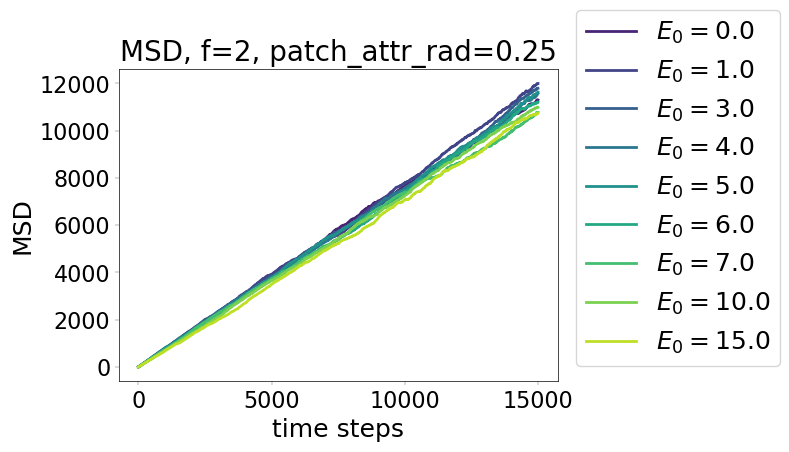

In [17]:
plot_ensemble_ave_msd(2, r=0.25)

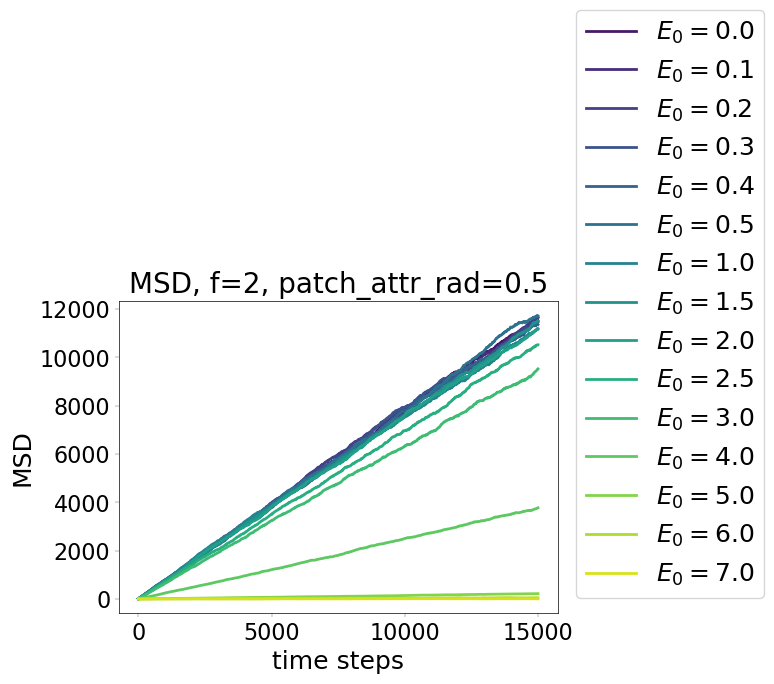

In [38]:
plot_ensemble_ave_msd(2, r=0.5)

11/21/23: Ran simulations with higher $E_0$ for f=1 and f=2. Also ran $E_0=0$ and $f=0$ cases for reference.

In [11]:
def plot_time_ave_msd_rep(f, r=0.35, repr=1.1, PBCbox=False):
    fig, ax = plt.subplots()
    if PBCbox:
        E0s = [float(str(path.name).split('_')[2][2:]) for path in simdir.glob(f"N1000_f{f}*_r{r}_rep{repr}")]
    else:
        E0s = [float(str(path.name).split('_')[2][2:]) for path in simdir.glob(f"N1000_f{f}*_rep{repr}_conf")]
    colors = sns.color_palette("viridis", len(E0s))
    for i, E0 in enumerate(np.sort(E0s)):
        if PBCbox:
            path = simdir/f"N1000_f{f}_E0{E0}_v0.3_r{r}_rep{repr}"
        else:
            path = simdir/f"N1000_f{f}_E0{E0}_v0.3_rep{repr}_conf"
        msdfile = path/'time_ave_msd_every_other_10_start5000.csv'
        if msdfile.is_file():
            msd_df = pd.read_csv(path/'time_ave_msd_every_other_10_start5000.csv')
            ax.plot(msd_df['Time'].values[1:], msd_df['MSD'].values[1:], 
                            label=f"$E_0={E0}$", color=colors[i])
    ax.set_xlabel("time steps")
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_ylabel("MSD")
    # Put a legend to the right of the current axis
    ax.legend(loc=(1.04, 0.05))
    ax.set_title(f"MSD, f={f}, repulsion_rad={repr}")

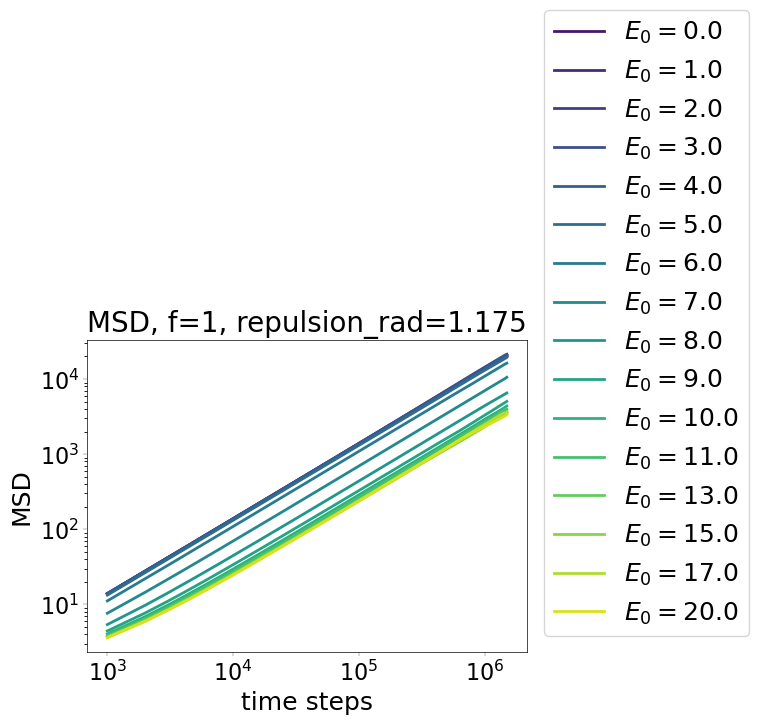

In [16]:
plot_time_ave_msd_rep(1, repr=1.175, PBCbox=True)

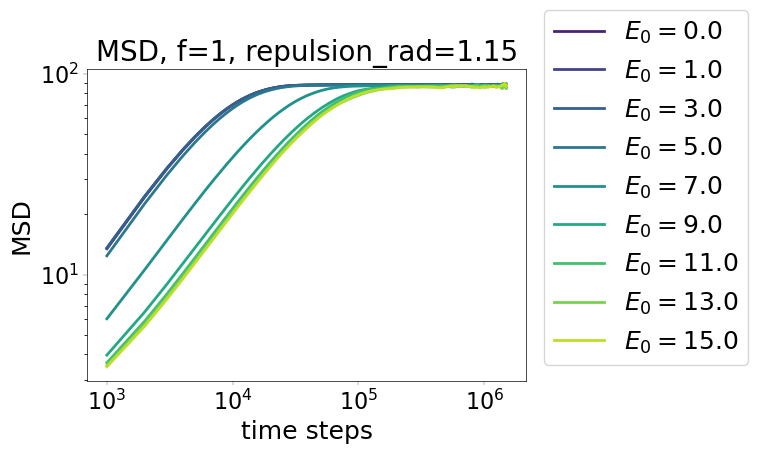

In [18]:
plot_time_ave_msd_rep(1, repr=1.15, PBCbox=False)

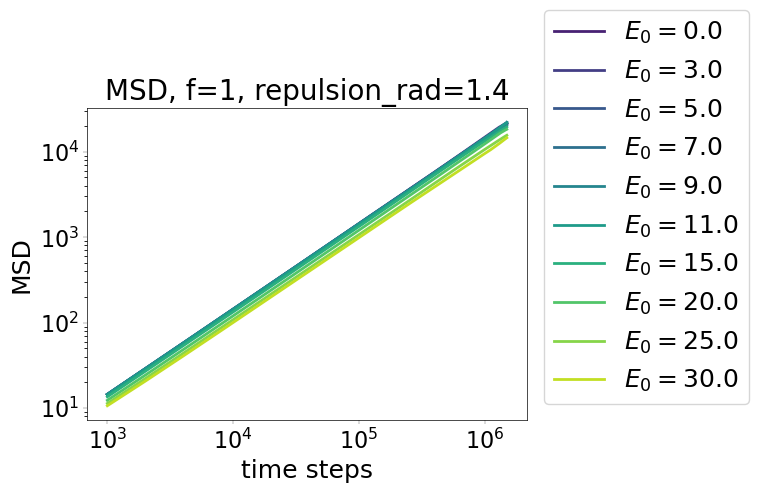

In [14]:
plot_time_ave_msd_rep(1, repr=1.4, PBCbox=True)

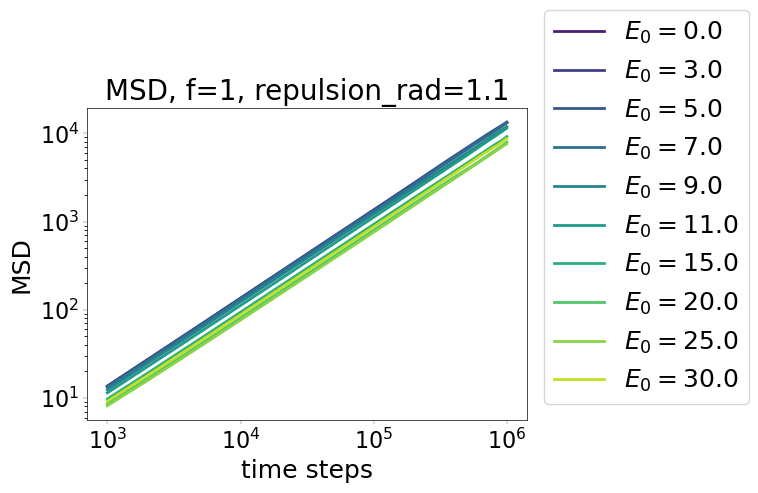

In [12]:
plot_time_ave_msd_rep(1, r=0.35, repr=1.1, PBCbox=True)

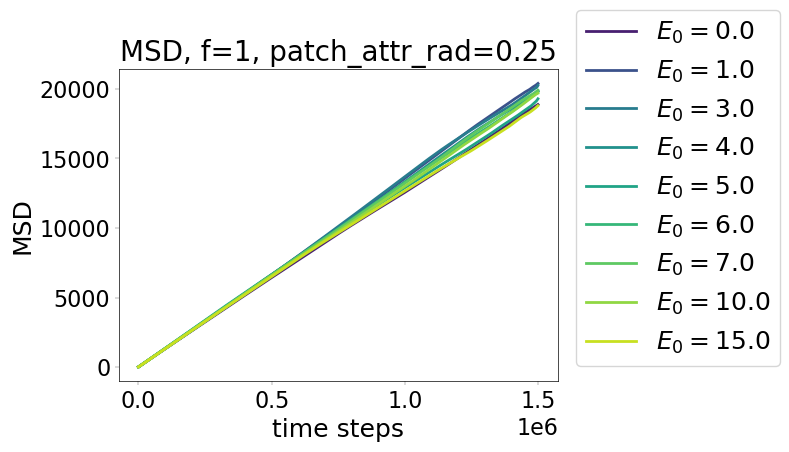

In [ ]:
f=1
r=0.25
plot_time_ave_msd(1)

In [23]:
def plot_time_ave_msd_fixedE0(E0, r=0.25):
    fig, ax = plt.subplots()
    fs = [int(str(path.name).split('_')[1][1:]) for path in simdir.glob(f"N1000_*E0{E0}*_r{r}")]
    colors = sns.color_palette("crest", len(fs))
    for i, f in enumerate(np.sort(fs)):
        path = simdir/f"N1000_f{f}_E0{E0}_v0.3_r{r}"
        msdfile = path/'time_ave_msd_every_other_10_start5000.csv'
        if msdfile.is_file():
            msd_df = pd.read_csv(path/'time_ave_msd_every_other_10_start5000.csv')
            ax.plot(msd_df['Time'].values[1:], msd_df['MSD'].values[1:], 
                            label=f"f={f}", color=colors[i])
    ax.set_xlabel("time steps")
    #ax.set_xscale("log")
    #ax.set_yscale("log")
    ax.set_ylabel("MSD")
    # Put a legend to the right of the current axis
    ax.legend(loc=(1.04, 0.05))
    ax.set_title(f"MSD, E0={E0}, patch_attr_rad={r}")

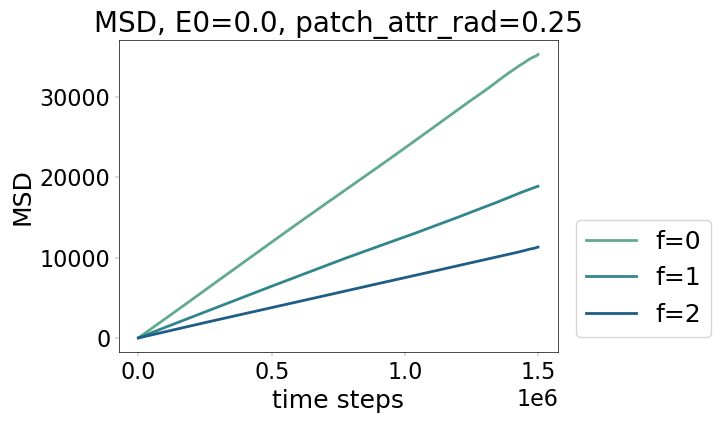

In [24]:
plot_time_ave_msd_fixedE0(0.0, r=0.25)

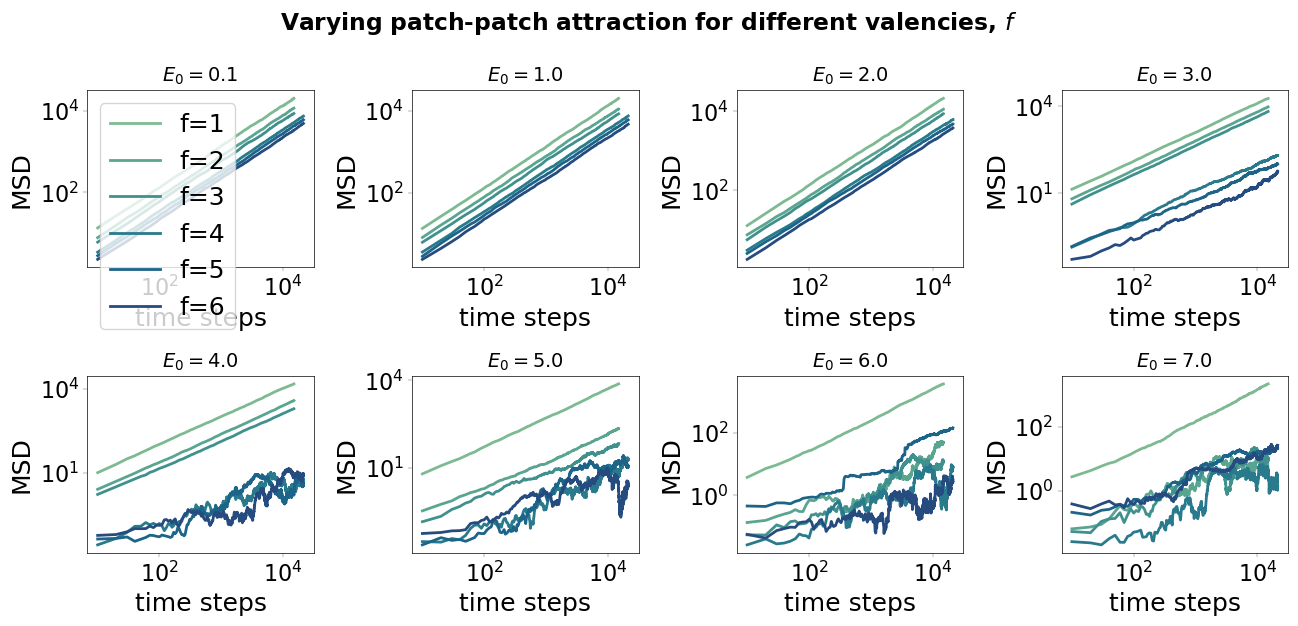

In [16]:
num_rows = 2
num_cols = 4
fig = plt.figure(figsize=(3*1.1*num_cols, 2 + 2*1.1*num_rows))
gs = GridSpec(nrows=num_rows, ncols=num_cols, 
                  width_ratios=[100]*num_cols)

i=0
E0s = [0.1, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0]
for E0, mat in path_df.groupby('E0'):
    mat = mat[mat["r"] == 0.5]
    if E0 in E0s:
        df = mat.sort_values('f')
        valencies = df['f'].values
        colors = sns.color_palette("crest", len(valencies))
        paths = df['path'].values

        #plot MSD
        x = i // num_cols
        y = i % num_cols
        ax = fig.add_subplot(gs[x, y])
        for j, path in enumerate(paths):
            msd_df = pd.read_csv(path/'sphere_msds_start5000_every_other_10.csv')
            if msd_df['Time'].values[0] != 0.0:
                ax.plot(msd_df['Time'].values[1:] - msd_df['Time'].values[0], msd_df['MSD'].values[1:], 
                        color=colors[j], label=f"f={valencies[j]}")
            else:
                ax.plot(msd_df['Time'].values[1:], msd_df['MSD'].values[1:], 
                        color=colors[j], label=f"f={valencies[j]}")
        ax.set_xlabel('time steps')
        ax.set_ylabel('MSD')
        ax.set_xscale('log')
        ax.set_yscale('log')
        if i == 0:
            ax.legend()
        ax.set_title(f"$E_0={E0}$", fontsize=14)
        i += 1

fig.suptitle(r"Varying patch-patch attraction for different valencies, $f$", fontweight='bold')
fig.tight_layout()
plt.savefig('plots/MSD_varyingE0_f1-6.pdf')

## Time lag averaging for better stats

Curves are noisy even after computing single trajectory MSD averaged over 1000 particles. 
Add time lag averaging for smoother curves.

In [39]:
def extract_particle_trajectory(f, E0, N=1000, v=0.3, start=5000, every_other=10,
                               simdir=Path('results')):
    """Load conformations from a simulation trajectory stored in the hdf5 files in simdir
    and store particle positions over time in a matrix X.

    Parameters
    ----------
    f : int
        valency
    E0 : float
        patch-patch attraction energy
    simdir : str or Path
        path to parent directory containing simulation folders named "N{N}_f{f}_E0{E0}_v{v}"
    start : int
        which time block to start loading conformations from
    every_other : int
        skip every_other time steps when loading conformations

    Returns
    -------
    X : array_like (num_t, num_particles, 3)
        x, y, z positions of all particles (excluding patches) over time

    """
    simdir = simdir/f"N{N}_f{f}_E0{E0}_v{v}"
    molecule_inds = np.arange(0, (f+1)*N, f+1).astype(int)
    totalN = (f + 1) * N
    X = []
    data = list_URIs(simdir)
    if start == 0:
        starting_pos = load_hdf5_file(Path(simdir) / "starting_conformation_0.h5")[
            "pos"
        ]
        X.append(starting_pos)
    for conformation in data[start::every_other]:
        pos = load_URI(conformation)["pos"]
        ncopies = pos.shape[0] // totalN
        for i in range(ncopies):
            posN = pos[totalN * i : totalN * (i + 1)]
            X.append(posN)
    X = np.array(X)
    Xparticle = X[:, molecule_inds, :]
    return Xparticle


@jit(nopython=True)
def get_bead_msd_time_ave(X):
    """Calculate time lag averaged MSDs of particles in a single simulation trajectory stored in X.

    Parameters
    ----------
    X : np.ndarray (num_t, num_particles, d)
        trajectory of particle positions in d dimensions over num_t timepoints
        
    Returns
    -------
    msd_ave : (num_t - 1,)
        time lag averaged MSD averaged over all particles

    """
    num_t, num_particles, d = X.shape
    msd = np.zeros((num_t - 1,))
    count = np.zeros((num_t - 1,))
    for i in range(num_t - 1):
        for j in range(i, num_t - 1):
            diff = X[j] - X[i]
            msd[j - i] += np.mean(np.sum(diff * diff, axis=-1))
            count[j - i] += 1
    msd_ave = msd / count
    return msd_ave

In [28]:
%%time
X = extract_particle_trajectory(4, 4.0)

(2143, 5000, 3)
(2143, 1000, 3)
CPU times: user 3.02 s, sys: 189 ms, total: 3.21 s
Wall time: 3.22 s


In [29]:
%%time
msd = get_bead_msd_time_ave(X)

CPU times: user 46.5 s, sys: 320 ms, total: 46.8 s
Wall time: 1min 3s


In [31]:
msd.shape

(2142,)

In [37]:
def save_time_ave_msd(f, E0, every_other=10):
    if f < 4:
        start = 5000
        time_per_step = 100
    else:
        start = 7142
        time_per_step = 70
    X = extract_particle_trajectory(f, E0, start=start, every_other=10)
    msd = get_bead_msd_time_ave(X)
    df = pd.DataFrame()
    #in units of femtoseconds (arbirtary unit used by openMM)
    df['Time'] = np.arange(0, len(msd)) * every_other * time_per_step
    df['MSD'] = msd
    path = Path(f"results/N1000_f{f}_E0{E0}_v0.3")
    df.to_csv(path/f'time_ave_msd_start{start}_every_other_10.csv', index=False)
    return df
    

In [42]:
%%time
df2 = save_time_ave_msd(4, 4.0)

CPU times: user 46.7 s, sys: 228 ms, total: 47 s
Wall time: 47 s


In [43]:
df

,Time,MSD
0,0,0.000000
1,1000,1.672662
2,2000,3.191239
3,3000,4.670998
4,4000,6.126073
...,...,...
1494,1494000,1911.284150
1495,1495000,1913.326750
1496,1496000,1914.397833
1497,1497000,1915.658063


In [41]:
%%time
df = save_time_ave_msd(3, 4.0)

CPU times: user 24.7 s, sys: 598 ms, total: 25.3 s
Wall time: 33.5 s


Text(0, 0.5, 'Time-averaged MSD')

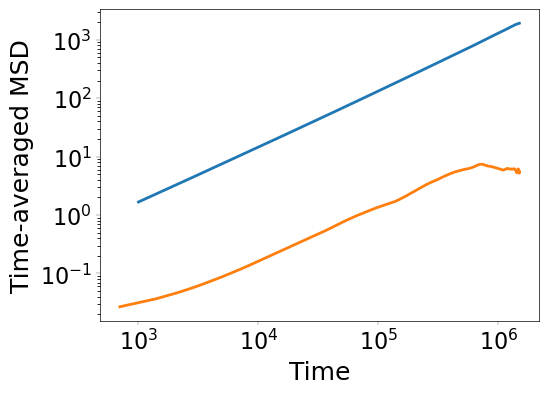

In [44]:
fig, ax = plt.subplots()
ax.plot(df['Time'].values[1:], df['MSD'].values[1:], label='f=3')
ax.plot(df2['Time'].values[1:], df2['MSD'].values[1:], label='f=4')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Time')
ax.set_ylabel('Time-averaged MSD')

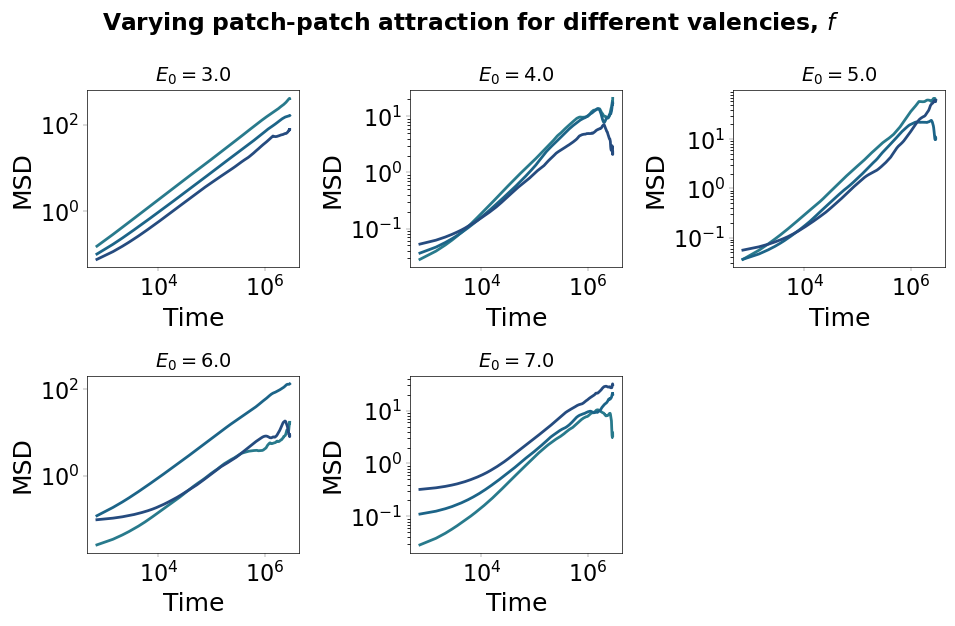

In [33]:
num_rows = 2
num_cols = 3
fig = plt.figure(figsize=(3*1.1*num_cols, 2 + 2*1.1*num_rows))
gs = GridSpec(nrows=num_rows, ncols=num_cols, 
                  width_ratios=[100]*num_cols)

i=0
E0s = [3.0, 4.0, 5.0, 6.0, 7.0]
for E0, mat in path_df.groupby('E0'):
    mat = mat[mat["r"] == 0.5]
    if E0 in E0s:
        df = mat.sort_values('f')
        valencies = df['f'].values
        colors = sns.color_palette("crest", len(valencies))
        paths = df['path'].values

        #plot MSD
        x = i // num_cols
        y = i % num_cols
        ax = fig.add_subplot(gs[x, y])
        for j, path in enumerate(paths):
            if valencies[j] < 4:
                msd_df = pd.read_csv(path/'time_ave_msd_every_other_10.csv')
            else:
                msd_df = pd.read_csv(path/'time_ave_msd_every_other_10_start7142.csv')
                ax.plot(msd_df['Time'].values[1:], msd_df['MSD'].values[1:], 
                        color=colors[j], label=f"f={valencies[j]}")
        ax.set_xlabel('Time')
        ax.set_ylabel('MSD')
        ax.set_xscale('log')
        ax.set_yscale('log')
        #if i == 0:
        #    ax.legend()
        ax.set_title(f"$E_0={E0}$", fontsize=14)
        i += 1

fig.suptitle(r"Varying patch-patch attraction for different valencies, $f$", fontweight='bold')
fig.tight_layout()
plt.savefig('plots/time_averaged_MSD_varyingE0_f1-6_long_times.pdf')

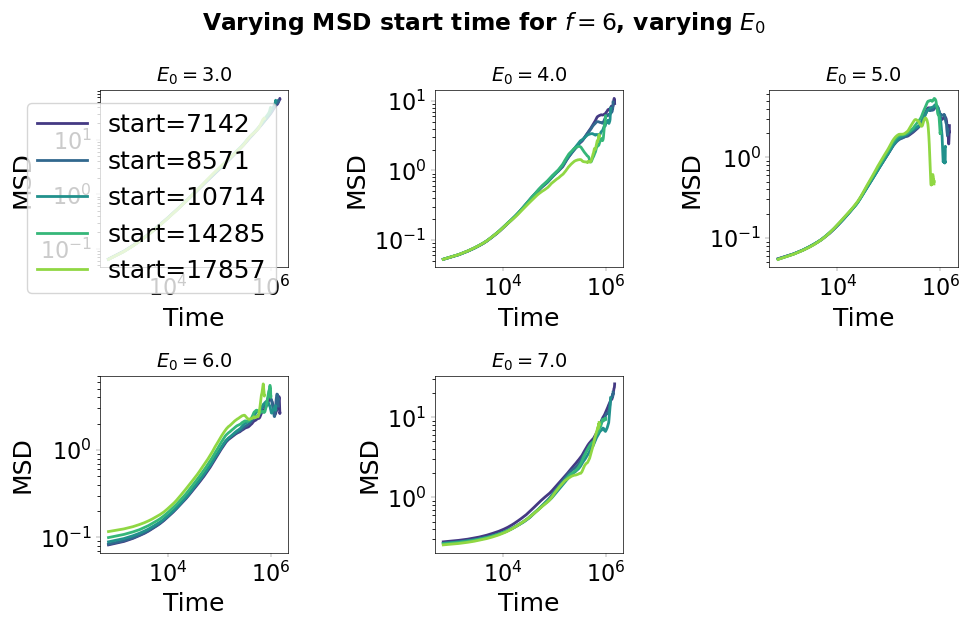

In [36]:
num_rows = 2
num_cols = 3
fig = plt.figure(figsize=(3*1.1*num_cols, 2 + 2*1.1*num_rows))
gs = GridSpec(nrows=num_rows, ncols=num_cols, 
                  width_ratios=[100]*num_cols)

i=0
E0s = [3.0, 4.0, 5.0, 6.0, 7.0]
timestep = 70

for E0 in E0s:
    path = simdir / f'N1000_f6_E0{E0}_v0.3'
    start_files = np.array([file for file in path.glob('time_ave_msd*start*.csv')])
    start_times = np.array([int(str(file.name).split('_')[-1].split('.')[0][5:]) for file in start_files])
    start_files = start_files[np.argsort(start_times)]
    start_times = start_times[np.argsort(start_times)]

    colors = sns.color_palette("viridis", len(start_times))

    #plot MSD
    x = i // num_cols
    y = i % num_cols
    ax = fig.add_subplot(gs[x, y])
    for j, file in enumerate(start_files):
        msd_df = pd.read_csv(file)
        ax.plot(msd_df['Time'].values[1:], msd_df['MSD'].values[1:], 
                    color=colors[j], label=f"start={start_times[j]}")
    ax.set_xlabel('Time')
    ax.set_ylabel('MSD')
    ax.set_xscale('log')
    ax.set_yscale('log')
    if i == 0:
        ax.legend()
    ax.set_title(f"$E_0={E0}$", fontsize=14)
    i += 1

fig.suptitle(r"Varying MSD start time for $f=6$, varying $E_0$", fontweight='bold')
fig.tight_layout()
plt.savefig('plots/time_averaged_MSD_varyingE0_f6_varying_starts.pdf')

In [28]:
path = simdir / f'N1000_f6_E03.0_v0.3'
timestep = 70
start_files = np.array([file for file in path.glob('time_ave_msd*start*.csv')])
start_times = np.array([int(str(file.name).split('_')[-1].split('.')[0][5:]) for file in start_files])
start_files[np.argsort(start_times)]

array([PosixPath('/net/levsha/share/deepti/simulations/protein_mobility/N1000_f6_E03.0_v0.3/time_ave_msd_every_other_10_start7142.csv'),
       PosixPath('/net/levsha/share/deepti/simulations/protein_mobility/N1000_f6_E03.0_v0.3/time_ave_msd_every_other_10_start8571.csv'),
       PosixPath('/net/levsha/share/deepti/simulations/protein_mobility/N1000_f6_E03.0_v0.3/time_ave_msd_every_other_10_start10714.csv'),
       PosixPath('/net/levsha/share/deepti/simulations/protein_mobility/N1000_f6_E03.0_v0.3/time_ave_msd_every_other_10_start14285.csv'),
       PosixPath('/net/levsha/share/deepti/simulations/protein_mobility/N1000_f6_E03.0_v0.3/time_ave_msd_every_other_10_start17857.csv')],
      dtype=object)

In [25]:
list(np.argsort(start_times))

[0, 4, 3, 1, 2]

In [27]:
start_times[[0,4,3,1,2]]

TypeError: list indices must be integers or slices, not list

## Quantify diffusion coefficient 

In [20]:
path_df[path_df['PBC']=='True']

,N,f,E0,v,r,rep_r,PBC,path
0,1000,2,0.0,0.3,0.50,1.175,True,/home/gridsan/dkannan/git-remotes/protein_mobi...
1,1000,2,3.0,0.3,0.50,1.250,True,/home/gridsan/dkannan/git-remotes/protein_mobi...
2,1000,2,5.0,0.3,0.25,1.050,True,/home/gridsan/dkannan/git-remotes/protein_mobi...
3,1000,3,0.4,0.3,0.50,1.050,True,/home/gridsan/dkannan/git-remotes/protein_mobi...
4,1000,2,7.0,0.3,0.50,1.250,True,/home/gridsan/dkannan/git-remotes/protein_mobi...
...,...,...,...,...,...,...,...,...
350,1000,4,7.0,0.3,0.50,1.050,True,/home/gridsan/dkannan/git-remotes/protein_mobi...
352,1000,1,20.0,0.3,0.50,1.175,True,/home/gridsan/dkannan/git-remotes/protein_mobi...
353,1000,3,2.5,0.3,0.50,1.050,True,/home/gridsan/dkannan/git-remotes/protein_mobi...
354,1000,1,2.0,0.3,0.50,1.100,True,/home/gridsan/dkannan/git-remotes/protein_mobi...


## From ensemble averaged MSDs

In [26]:
Dapps = []
alphas = []
for path in path_df['path'].values:
    if (path/'sphere_msds_start5000_every_other_10.csv').is_file():
        msd_df = pd.read_csv(path/'sphere_msds_start5000_every_other_10.csv')
        result = sp.stats.linregress(msd_df['Time'].values - msd_df['Time'].values[0], msd_df['MSD'].values)
        print(f"Fit from linear space: {result.slope}t + {result.intercept}")
        log_result = sp.stats.linregress(np.log10(msd_df['Time'].values[1:] - msd_df['Time'].values[0]), np.log10(msd_df['MSD'].values[1:]))
        print(f"Fit from log space: {10**log_result.intercept}, alpha={log_result.slope}")
        Dapps.append(result.slope)
    else:
        Dapps.append(0.0)
path_df['Dapp'] = Dapps

Fit from linear space: 0.2794239554001905t + -7.015012125587873
Fit from log space: 0.25431077942821373, alpha=1.0096564309012528
Fit from linear space: 0.7030199027500083t + -33.38070749464532
Fit from log space: 0.7098311492235028, alpha=0.9980397299717595
Fit from linear space: 0.0007166653853770028t + 3.7857802366266977
Fit from log space: 0.014581408665224088, alpha=0.7170548650121606
Fit from linear space: 0.006667469625628553t + 10.256476840675447
Fit from log space: 0.0033399082724157895, alpha=1.0874316244246924
Fit from linear space: 1.2554549848026995t + 113.46440702109976
Fit from log space: 1.3197028219251177, alpha=0.9960362182906705
Fit from linear space: 1.3320651895273712t + -59.81653091964654
Fit from log space: 1.405552871053128, alpha=0.9932461901566116
Fit from linear space: 0.5974017866386675t + -25.780572532145925
Fit from log space: 0.5841175528718225, alpha=1.001762837921985
Fit from linear space: 0.252982281028939t + -40.58132201736453
Fit from log space: 0.20

Fit from linear space: 0.5152268635947157t + -9.636877640393777
Fit from log space: 0.49466114804696787, alpha=1.0041384719940785
Fit from linear space: 0.00056851966821764t + 5.112870657644327
Fit from log space: 0.004722863300950779, alpha=0.840947213647689
Fit from linear space: 0.1292331137939644t + 5.726288401436932
Fit from log space: 0.1457819181673188, alpha=0.9873517819085935
Fit from linear space: 0.7707642151709301t + 74.35197706227882
Fit from log space: 0.7522319860521108, alpha=1.0043594147353516
Fit from linear space: 0.7623058468475121t + -18.6364161481024
Fit from log space: 0.6945261902758096, alpha=1.0099231379049785


In [10]:
msd_df = pd.read_csv('results/N1000_f3_E00.5_v0.3/sphere_msds_start5000_every_other_10.csv')
msd_df

,Time,MSD
0,0,0.000000
1,10,5.607067
2,20,11.797545
3,30,17.395723
4,40,22.691092
...,...,...
1495,14950,8633.661000
1496,14960,8643.843000
1497,14970,8646.640000
1498,14980,8644.898000


In [22]:
#flory huggins spinodal prediction: chi has to be larger than this value

def chi(phi, f):
    return (1 + (f - 1)*phi)/(2*f*phi*(1 - phi))

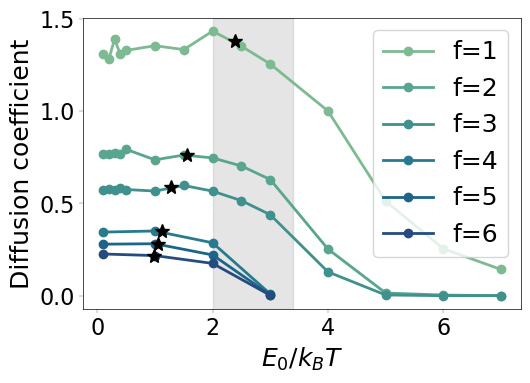

In [37]:
from scipy.interpolate import CubicSpline

fig, ax = plt.subplots()
colors = sns.color_palette("crest", 6)
for f, mat in path_df.groupby('f'):
    mat = mat[mat["r"]==0.5]
    df = mat.sort_values('E0')
    if f >= 4:
        ax.plot(df['E0'].values[0:4], df['Dapp'].values[0:4], '-o', label=f"f={f}", color=colors[f-1])
        cs = CubicSpline(df['E0'].values[0:4], df['Dapp'].values[0:4])
    else:
        ax.plot(df['E0'], df['Dapp'], '-o', label=f"f={f}", color=colors[f-1])
        cs = CubicSpline(df['E0'], df['Dapp'])
    #flory huggins prediction for spinodal -- chi(0.3)
    chi_critical = chi(0.3, f)
    ax.plot(chi_critical, cs(chi_critical), '*', color="k", markersize=10)

ax.axvspan(2, 2 + np.log(4), color='grey', alpha=0.2)
ax.legend()
#ax.set_yscale('log')
ax.set_xlabel('$E_0 / k_B T$')
ax.set_ylabel('Diffusion coefficient')
fig.tight_layout()
plt.savefig('plots/diffusion_coefficient_vs_E0_f1-6_flory_huggins_shade.pdf')

## From time averaged MSDs

In [13]:
from scipy.stats import t

Dapps = []
alphas = []
for path in path_df['path'].values:
    if (path/'time_ave_msd_every_other_10_start5000.csv').is_file():
        msd_df = pd.read_csv(path/'time_ave_msd_every_other_10_start5000.csv')
        result = sp.stats.linregress(msd_df['Time'].values[1:], msd_df['MSD'].values[1:])
        log_result = sp.stats.linregress(np.log10(msd_df['Time'].values[1:]), np.log10(msd_df['MSD'].values[1:]))
        if 'rep' in path.name:
            print(path)
            print(f"Fit from linear space (95%): {result.slope}t")
            print(f"Fit from log space: {10**log_result.intercept}, alpha={log_result.slope}")
        Dapps.append(result.slope)
        alphas.append(log_result.slope)
    else:
        Dapps.append(np.nan)
        alphas.append(np.nan)
path_df['Dapp'] = Dapps
path_df['alphas'] = alphas

/home/gridsan/dkannan/git-remotes/protein_mobility/results/N1000_f2_E00.0_v0.3_rep1.175
Fit from linear space (95%): 0.00782653455405454t
Fit from log space: 0.009339670814796995, alpha=0.9879576206612636
/home/gridsan/dkannan/git-remotes/protein_mobility/results/N1000_f2_E03.0_v0.3_rep1.25
Fit from linear space (95%): 0.008264572828038315t
Fit from log space: 0.008910330008319492, alpha=0.9953377788286913
/home/gridsan/dkannan/git-remotes/protein_mobility/results/N1000_f1_E011.0_v0.3_r0.35_rep1.05
Fit from linear space (95%): 0.006865868819149433t
Fit from log space: 0.006944305973467561, alpha=0.9991552175118088
/home/gridsan/dkannan/git-remotes/protein_mobility/results/N1000_f1_E011.0_v0.3_rep1.35
Fit from linear space (95%): 0.013300326765079083t
Fit from log space: 0.012523488035180212, alpha=1.0039493140649172
/home/gridsan/dkannan/git-remotes/protein_mobility/results/N1000_f1_E011.0_v0.3_r0.3_rep1.1
Fit from linear space (95%): 0.012240356861322665t
Fit from log space: 0.0160871

In [12]:
path_df

,N,f,E0,v,r,rep_r,PBC,path,Dapp,alphas
0,1000,2,0.0,0.3,0.5,1.05,True,/home/gridsan/dkannan/git-remotes/protein_mobi...,0.007827,0.987958
1,1000,2,3.0,0.3,0.5,1.05,True,/home/gridsan/dkannan/git-remotes/protein_mobi...,0.008265,0.995338
2,1000,2,5.0,0.3,0.5,1.05,True,/home/gridsan/dkannan/git-remotes/protein_mobi...,0.007669,0.999696
3,1000,1,11.0,0.3,0.5,1.05,True,/home/gridsan/dkannan/git-remotes/protein_mobi...,0.013300,1.003949
4,1000,1,11.0,0.3,0.3,1.10,True,/home/gridsan/dkannan/git-remotes/protein_mobi...,0.012240,0.981275
...,...,...,...,...,...,...,...,...,...,...
500,1000,1,20.0,0.3,0.5,1.05,True,/home/gridsan/dkannan/git-remotes/protein_mobi...,0.002228,0.980302
501,1000,3,2.5,0.3,0.5,1.05,True,/home/gridsan/dkannan/git-remotes/protein_mobi...,NaN,NaN
502,1000,1,2.0,0.3,0.5,1.05,True,/home/gridsan/dkannan/git-remotes/protein_mobi...,0.010372,1.001301
503,1000,4,2.0,0.3,0.5,1.05,True,/home/gridsan/dkannan/git-remotes/protein_mobi...,NaN,NaN


In [14]:
def plot_diffusion(r, repr, PBCbox, path_df):
    fig, ax = plt.subplots()
    colors = sns.color_palette("crest", 6)
    df = path_df[path_df['PBC']==PBCbox]
    df = df[df["r"]==r]
    df = df[df["rep_r"]==repr]
    i=0
    for f, mat in df.groupby('f'):
        df = mat.sort_values('E0')
        print(df['Dapp'])
        if f >= 4:
            ax.plot(df['E0'].values[0:4], df['Dapp'].values[0:4], '-o', label=f"f={f}", color=colors[f-1])
        else:
            ax.plot(df['E0'].values[:-1], df['Dapp'].values[:-1], '-o', label=f"f={f}", color=colors[i])
            i += 1

    ax.legend()
    #ax.set_yscale('log')
    ax.set_xlabel('$E_0 / k_B T$')
    ax.set_ylabel('Diffusion coefficient')
    fig.tight_layout()
    plt.savefig(f'plots/diffusion_coefficient_vs_E0_f1-2_r{r}.pdf')

306    0.013355
11     0.013306
303    0.013513
209    0.013058
67     0.011889
460    0.011458
106    0.009137
27     0.007822
515    0.007662
331    0.008722
Name: Dapp, dtype: float64
356    0.008161
212    0.008123
245    0.007339
102    0.006947
170    0.005739
442    0.004838
456    0.003337
301    0.002505
277    0.002260
284    0.002310
Name: Dapp, dtype: float64


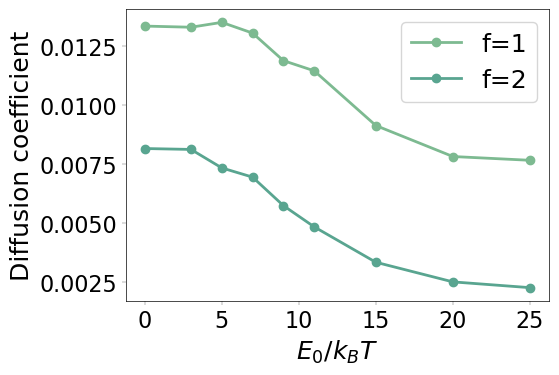

In [15]:
plot_diffusion(0.35, 1.1, 'True', path_df)

526    0.012595
500    0.012958
6      0.013153
270    0.011294
160    0.008830
3      0.006866
79     0.004881
283    0.004305
361    0.005551
477    0.007024
Name: Dapp, dtype: float64
308    0.007662
130    0.007482
333    0.006677
294    0.004697
104    0.003093
74     0.002127
250    0.001101
292    0.000816
129    0.000664
310    0.001388
Name: Dapp, dtype: float64


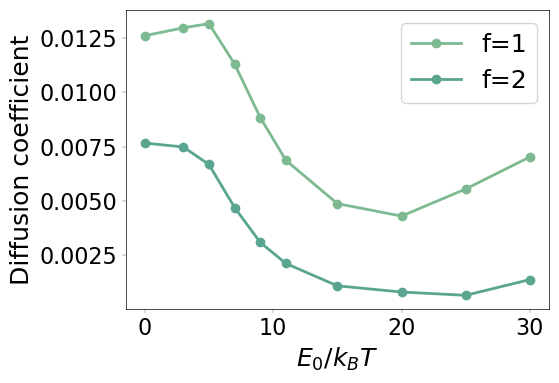

In [17]:
plot_diffusion(0.35, 1.05, 'True', path_df)

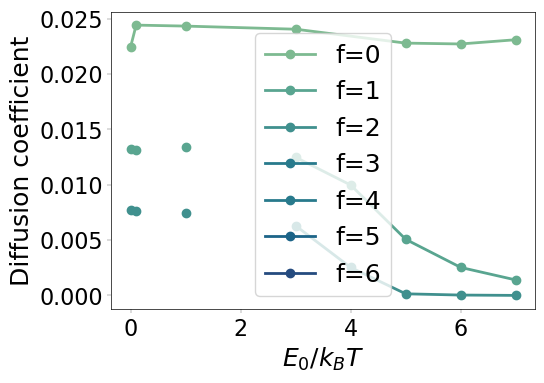

In [49]:
plot_diffusion(0.5, path_df)

128    0.018075
219    0.017770
136    0.017718
11     0.018043
112    0.018038
26     0.018186
28     0.017715
Name: Dapp, dtype: float64
70     0.010703
225    0.010372
141    0.010561
37     0.009164
151    0.002930
163    0.002079
Name: Dapp, dtype: float64
192    0.005817
105    0.005862
210    0.004938
16     0.002896
80     0.000645
187    0.000047
Name: Dapp, dtype: float64


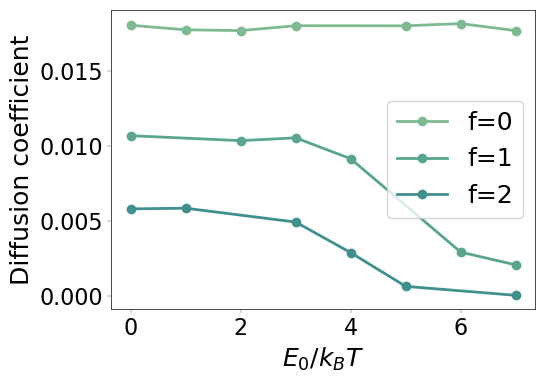

In [12]:
plot_diffusion(0.5, 1.1, path_df)

231    0.011694
202    0.011111
237    0.011291
161    0.011647
286    0.011940
96     0.011836
232    0.011162
106    0.011483
Name: Dapp, dtype: float64
262    0.006631
259    0.000002
302    0.000002
295    0.006275
182    0.006463
170    0.000002
111    0.006767
28     0.006882
123    0.005404
132    0.000002
176    0.003051
93     0.001733
88     0.000004
153    0.000008
43     0.000008
253    0.000009
82     0.000010
Name: Dapp, dtype: float64
105    0.003548
195    0.000003
166    0.003533
220    0.000003
218    0.003530
48     0.003276
250    0.000003
219    0.002778
58     0.000005
141    0.001291
260    0.000379
298    0.000082
297    0.000024
244    0.000028
214    0.000027
23     0.000013
109    0.000005
Name: Dapp, dtype: float64


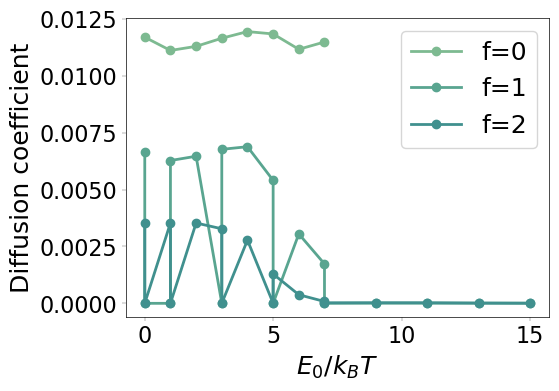

In [19]:
plot_diffusion(0.5, 1.15, 'False', path_df)

340    0.014690
271    0.014151
212    0.014465
353    0.013788
37     0.013989
422    0.014490
63     0.014351
62     0.014123
51     0.012977
449    0.011938
Name: Dapp, dtype: float64
158    0.008741
403    0.008737
282    0.008697
121    0.008369
109    0.008759
141    0.008347
13     0.007205
176    0.005194
26     0.003931
238    0.003365
Name: Dapp, dtype: float64


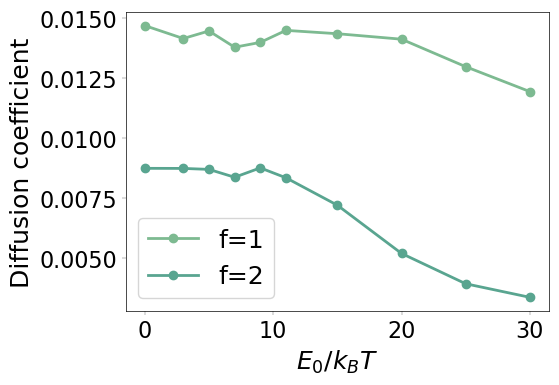

In [22]:
plot_diffusion(0.5, 1.45, 'True', path_df)

153    0.014104
157    0.014180
133    0.013375
132    0.013682
12     0.014305
86     0.013324
177    0.014275
220    0.013179
124    0.011904
113    0.009630
83     0.007388
Name: Dapp, dtype: float64
184    0.008086
138    0.008352
156    0.008475
1      0.008265
164    0.008149
53     0.007637
57     0.007319
4      0.005802
135    0.004014
84     0.002716
167    0.002122
Name: Dapp, dtype: float64


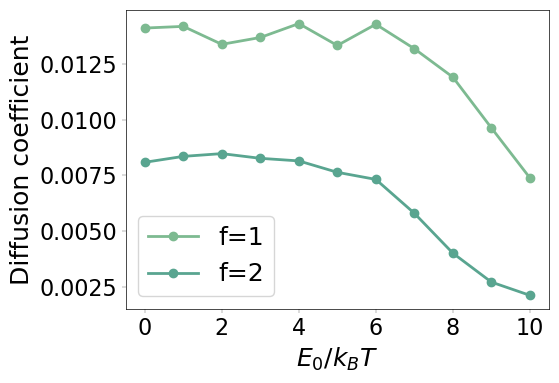

In [17]:
plot_diffusion(0.5, 1.25, path_df)

In [31]:
def plot_diffusion_multiple_repr(f, r, path_df):
    fig, ax = plt.subplots()
    colors = sns.color_palette("crest", 10)
    df = path_df[path_df["r"]==r]
    df = df[df['PBC']=='True']
    df = df[df["f"]==f]
    i=0
    for rep_r, mat in df.groupby('rep_r'):
        if rep_r > 1.15:
            df = mat.sort_values('E0')
            print(f'Repulsion radius {rep_r}')
            print(df['Dapp'])
            if f >= 4:
                ax.plot(df['E0'].values[0:4], df['Dapp'].values[0:4], '-o', label=f"f={f}", color=colors[f-1])
            else:
                ax.plot(df['E0'], df['Dapp'], '-o', label=f"rep_r={rep_r}", color=colors[i])
                i += 1

    # Put a legend to the right of the current axis
    ax.legend(loc=(1.04, 0.05))
    #ax.set_yscale('log')
    ax.set_xlabel('$E_0 / k_B T$')
    ax.set_ylabel('Diffusion coefficient')
    #fig.tight_layout()
    plt.savefig(f'plots/diffusion_coefficient_vs_E0_f{f}_rep_r_sweep.pdf')

Repulsion radius 1.175
311    0.013502
48     0.013467
179    0.014147
145    0.014526
337    0.014051
34     0.012966
201    0.010941
339    0.007038
209    0.004380
241    0.003359
106    0.002917
267    0.002654
45     0.002400
44     0.002322
175    0.002511
452    0.002228
Name: Dapp, dtype: float64
Repulsion radius 1.2
174    0.013931
142    0.014652
50     0.013655
144    0.014302
253    0.013888
108    0.013391
404    0.012590
169    0.009904
87     0.006574
31     0.004199
321    0.003523
113    0.003145
25     0.002713
110    0.002525
302    0.002512
77     0.002429
Name: Dapp, dtype: float64
Repulsion radius 1.225
11     0.013813
132    0.013872
218    0.013616
367    0.013653
53     0.013835
410    0.013769
71     0.013472
101    0.012065
396    0.009344
112    0.006528
350    0.004926
38     0.004105
351    0.003165
75     0.003015
194    0.002795
190    0.002672
Name: Dapp, dtype: float64
Repulsion radius 1.25
312    0.014104
319    0.014180
276    0.013374
275    0.01368

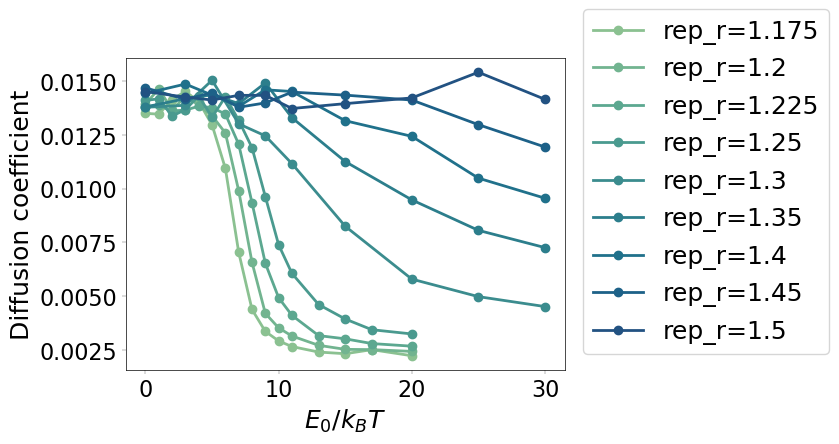

In [32]:
plot_diffusion_multiple_repr(1, 0.5, path_df)

## Plot patch-patch attraction potential

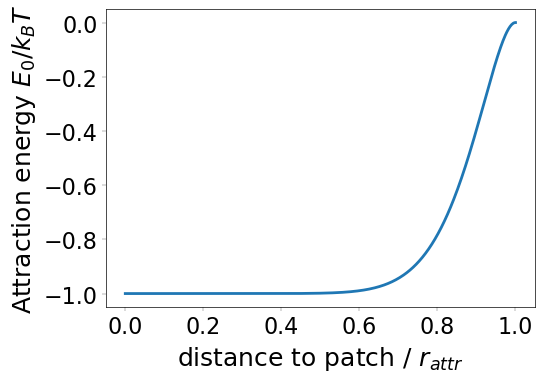

In [40]:
def f(x):
    term1 = (x/0.5)* np.sqrt(6/7)
    term2 = 1 + (term1**12) * (term1**2 - 1) * (823543/46656)
    return -1 * term2

x = np.linspace(0,0.5,500)
fig, ax = plt.subplots()
plt.plot(x / 0.5,f(x))
plt.xlabel(r"distance to patch / $r_{attr}$")
plt.ylabel("Attraction energy $E_0 / k_B T$")
fig.tight_layout()
plt.savefig('plots/patch_attraction_potential.pdf')

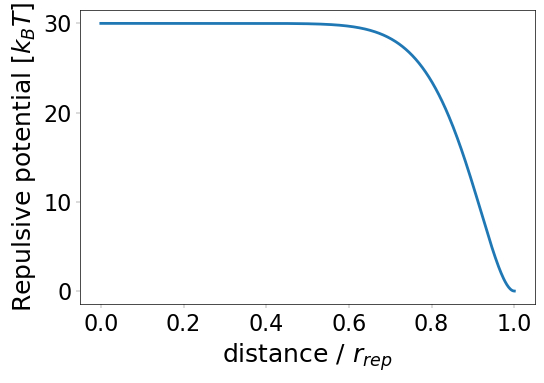

In [42]:
def f(x):
    term1 = ( x* np.sqrt(6/7)) / (1.05 )
    term2 = 1 + (term1**12) * (term1**2 - 1) * (823543/46656)
    return 30.0 * term2

x = np.linspace(0,1.05,500)
fig, ax = plt.subplots()
plt.plot(x / 1.05, f(x))
plt.xlabel("distance / $r_{rep}$")
plt.ylabel("Repulsive potential [$k_B T$]")
fig.tight_layout()
plt.savefig('plots/sphere_repulsive_potential.pdf')

In [21]:
#flory huggins spinodal prediction: chi has to be larger than this value

def chi(phi, f):
    return (1 + (f - 1)*phi)/(2*f*phi*(1 - phi))

print(chi(0.3, 1))
print(chi(0.3, 2))
print(chi(0.3, 3))
print(chi(0.3, 4))  
print(chi(0.3, 5))
print(chi(0.3, 6))

2.380952380952381
1.5476190476190477
1.2698412698412702
1.130952380952381
1.047619047619048
0.9920634920634922


## Plots for paper

In [53]:
cm_in_inch = 2.54
pnas_params = {
    'backend': 'pdf',
    'savefig.format': 'pdf',
    'text.usetex': False,
    'font.size': 8,

    'figure.figsize': [4.35 / cm_in_inch, 4 / cm_in_inch],
    'figure.facecolor': 'white',

    'axes.grid': False,
    'axes.edgecolor': 'black',
    'axes.facecolor': 'white',

    'axes.titlesize': 8.0,
    'axes.labelsize': 8,
    'legend.fontsize': 8,
    'xtick.labelsize': 8,
    'ytick.labelsize': 8,
    'axes.linewidth': 0.8,

    'xtick.top': False,
    'xtick.bottom': True,
    'xtick.direction': 'in',
    'xtick.minor.size': 1.5,
    'xtick.minor.width': 0.6,
    'xtick.major.pad': 2,
    'xtick.major.size': 3,
    'xtick.major.width': 0.8,

    'ytick.left': True,
    'ytick.right': False,
    'ytick.direction': 'in',
    'ytick.minor.size': 1.5,
    'ytick.minor.width': 0.6,
    'ytick.major.pad': 2,
    'ytick.major.size': 3,
    'ytick.major.width': 0.8,

    'lines.linewidth': 1.6
}
plt.rcParams.update(pnas_params)

In [65]:
def plot_diffusion(r, repr, PBCbox, path_df):
    fig, ax = plt.subplots()
    colors = sns.color_palette("crest", 6)
    df = path_df[path_df['PBC']==PBCbox]
    df = df[df["r"]==r]
    df = df[df["rep_r"]==repr]
    df = df[df['f'] == 2]
    df = df.dropna()
    df = df.sort_values('E0')
    D0 = float(df[df['E0']==0.0]['Dapp'])
    print(D0)
    ax.plot(df['E0'].values[:-1], df['Dapp'].values[:-1]/D0, 'k-o', label=f"f={f}")
    ax.axhline(1.0, color='k', linestyle='dashed')
    #ax.set_yscale('log')
    ax.set_xlabel('$E_{attr} / k_B T$')
    ax.set_ylabel('$D_{f=2} / D_{f=0}$')
    ax.set_ylim(top=1.1)
    fig.tight_layout()
    plt.savefig(f'plots/normalized_diffusion_coefficient_vs_E0_f2_r{r}_rep{repr}.pdf')

/tmp/ipykernel_1137875/2495409205.py:8: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  D0 = float(df[df['E0']==0.0]['Dapp'])


0.007720069286261704


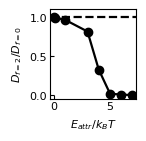

In [66]:
plot_diffusion(0.5, path_df)

In [71]:
from sklearn.cluster import DBSCAN

def extract_trajectory(simdir, wrap=False, start=0, end=-1, every_other=10):
    """Load conformations from a simulation trajectory stored in the hdf5 files in simdir.
    
    Parameters
    ----------
    simdir : str or Path
        path to simulation directory containing .h5 files
    start : int
        which time block to start loading conformations from
    end : int
        which time block to stop loading conformations from
    every_other : int
        skip every_other time steps when loading conformations
        
    Returns
    -------
    X : array_like (num_t, N, 3)
        x, y, z positions of all monomers over time
    
    """
    X = []
    data = list_URIs(simdir)
    #check if PBCbox was used
    initArgs = load_hdf5_file(Path(simdir)/"initArgs_0.h5")
    PBCbox = np.array(initArgs['PBCbox'])
    if PBCbox.any():
        boxsize = PBCbox
    if start == 0:
        starting_pos = load_hdf5_file(Path(simdir)/"starting_conformation_0.h5")['pos']
        X.append(starting_pos)
    for conformation in data[start:end:every_other]:
        pos = load_URI(conformation)['pos']
        if PBCbox.any() and wrap:
            mults = np.floor(pos / boxsize[None, :])
            pos = pos - mults * boxsize[None, :]
            assert pos.min() >= 0
        X.append(pos)
    X = np.array(X)
    return X

def cluster_size_distribution(f, E0, N=1000, vol_fraction=0.3, r=None,
                              cutoff=1.2, wrap=False):
    if r:
        Y = extract_trajectory(simdir/f"N{N}_f{f}_E0{E0}_v{vol_fraction}_r{r}", wrap=wrap, 
                               start=10000, every_other=100)
    else:
        Y = extract_trajectory(simdir/f"N{N}_f{f}_E0{E0}_v{vol_fraction}", wrap=wrap, 
                               start=10000, every_other=100)
    #indices of larger spheres
    molecule_inds = np.arange(0, (f+1)*N, f+1)
    cluster_sizes = []
    for i in range(Y.shape[0]):
        X = Y[i, molecule_inds, :]
        clustering = DBSCAN(eps=cutoff, min_samples=2).fit(X)
        cluster_labels, counts = np.unique(clustering.labels_, return_counts=True)
        #first element of counts represents number of monomers
        cluster_sizes += counts[0] * [1] + list(counts[1:])
    return cluster_sizes

In [80]:
def plot_multimerization(f, cutoff=1.1, r=None):
    fig, ax = plt.subplots()
    colors = ['k', '#00BAC4', '#004B7E']
    E0_values = [0.0, 2.0, 4.0]
    for i, E0 in enumerate(E0_values):
        cluster_sizes = cluster_size_distribution(f, E0, cutoff=cutoff, r=r, wrap=True)
        counts, bins, patches = ax.hist(cluster_sizes, bins=np.arange(0, 1000, 1), density=True, 
                                        cumulative=True, histtype='step', color=colors[i], label=r'$E_{attr}$' + f'={E0}')
    ax.set_xlabel('Cluster size')
    ax.set_ylabel('CDF')
    ax.set_xlim(0, 10)
    ax.legend(loc='lower right')
    if r is None:
        r = 0.5
    fig.tight_layout()
    plt.savefig(f'plots/multimerization_f{f}_cutoff{cutoff}_r{r}.pdf')

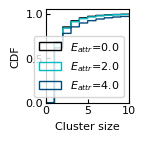

In [81]:
plot_multimerization(2)